##  NYC Taxi Fares dataset
The <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle NYC Taxi Fares </a> provides a dataset with about 55 million records. The data contains only the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers. It is up to the contest participant to extract any further information. For instance, does the time of day matter? The day of the week? How do we determine the distance traveled from pairs of GPS coordinates?

For this we've whittled the dataset down to just 60,000 records from April 11 to April 24, 2010. The records are randomly sorted. We'll calculate distance from GPS coordinates by using <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> and also extract the information like day of the week, am vs. pm, etc. as a part of Feature Engineering



In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv(r'Desktop/NYCTaxiFares.csv')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [3]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

From this we see that fares range from \\$2.50 to \\$49.90, with a mean of \\$10.04 and a median of \\$7.70

# Feature Engineering


### Calculating the distance from GPS coordinates

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


### Adding a datetime column to extract information 

Note that the data was saved in UTC time. Our data falls in April of 2010 which occurred during Daylight Savings Time in New York. For that reason, we'll make an adjustment to EDT using UTC-4 (subtracting four hours).

In [6]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01,22,pm,Fri


In [7]:
df['EDTdate'].min()

Timestamp('2010-04-11 00:00:10')

In [8]:
df['EDTdate'].max()

Timestamp('2010-04-24 23:59:42')

## Separate categorical and continuous Features

In [9]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [10]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

## Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes".

In [11]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [12]:
df.dtypes

pickup_datetime              object
fare_amount                 float64
fare_class                    int64
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dist_km                     float64
EDTdate              datetime64[ns]
Hour                       category
AMorPM                     category
Weekday                    category
dtype: object

We can see that <tt>df['Hour']</tt> is a categorical feature by displaying some of the rows:

In [13]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23]

Here our categorical names are the integers 0 through 23, for a total of 24 unique categories. These values <em>also</em> correspond to the codes assigned to each name.

We can access the category names with <tt>Series.cat.categories</tt> or just the codes with <tt>Series.cat.codes</tt>. This will make more sense if we look at <tt>df['AMorPM']</tt>:

In [14]:
df['AMorPM'].head()

0    am
1    am
2    am
3    pm
4    pm
Name: AMorPM, dtype: category
Categories (2, object): [am, pm]

In [15]:
df['AMorPM'].cat.categories

Index(['am', 'pm'], dtype='object')

In [16]:
df['AMorPM'].head().cat.codes

0    0
1    0
2    0
3    1
4    1
dtype: int8

In [17]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [18]:
df['Weekday'].head().cat.codes

0    1
1    2
2    2
3    3
4    0
dtype: int8

<div class="alert alert-info"><strong>NOTE: </strong>NaN values in categorical data are assigned a code of -1. We don't have any in this particular dataset.</div>

Now we want to combine the three categorical columns into one input array using <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a> We don't want the Series index, just the values.

In [19]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

cats = np.stack([hr, ampm, wkdy], 1)

cats[:5]

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       [17,  1,  3],
       [22,  1,  0]], dtype=int8)

## Convert numpy arrays to tensors

In [20]:
# Convert categorical variables to a tensor
cats = torch.tensor(cats, dtype=torch.int64) 
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 4,  0,  1],
        [11,  0,  2],
        [ 7,  0,  2],
        [17,  1,  3],
        [22,  1,  0]])

We can feed all of our continuous variables into the model as a tensor. Note that we're not normalizing the values here; we'll let the model perform this step.
<div class="alert alert-info"><strong>NOTE:</strong> We have to store <tt>conts</tt> and <tt>y</tt> as Float (float32) tensors, not Double (float64) in order for batch normalization to work properly.</div>

In [21]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts[:5]

tensor([[ 40.7305, -73.9924,  40.7447, -73.9755,   1.0000,   2.1263],
        [ 40.7406, -73.9901,  40.7441, -73.9742,   1.0000,   1.3923],
        [ 40.7511, -73.9941,  40.7662, -73.9601,   2.0000,   3.3268],
        [ 40.7564, -73.9905,  40.7482, -73.9712,   1.0000,   1.8641],
        [ 40.7342, -73.9910,  40.7431, -73.9060,   1.0000,   7.2313]])

In [22]:
conts.type()

'torch.FloatTensor'

In [23]:
# Convert labels to a tensor
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

y[:5]

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        [ 8.9000],
        [19.7000]])

In [24]:
cats.shape

torch.Size([120000, 3])

In [25]:
conts.shape

torch.Size([120000, 6])

In [26]:
y.shape

torch.Size([120000, 1])

## Setting an embedding Layer size for ANN
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [27]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

## Define a TabularModel for Artificial Neural Network
This somewhat follows the <a href='https://docs.fast.ai/tabular.models.html'>fast.ai library</a> The goal is to define a model based on the number of continuous columns (given by <tt>conts.shape[1]</tt>) plus the number of categorical columns and their embeddings (given by <tt>len(emb_szs)</tt> and <tt>emb_szs</tt> respectively). The output would either be a regression (a single float value), or a classification (a group of bins and their softmax values). 

In [28]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        """ The 'out_sz' indicates the number of output results 
            and it will be 1 for Linear regression models
            and 2 for Binary classification model and more than 2 for multi classification models"""
        
        """ The layers parameter will accpet a list of neurons for each layer, (ie) [200,100] which menas there 
            will be 2 hidden layers with 200 neurons in first hidden layer and 100 neurons in the second hidden layer"""
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True)) #can modify the activation function in need
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p)) #to dropout some percentage of neurons to reduce teh overfitting of the model
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist) ##creating the ANN Layers 
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [29]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [30]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

## Define loss function & optimizer
PyTorch does not offer a built-in <a href='https://en.wikipedia.org/wiki/Root-mean-square_deviation'>RMSE Loss</a> function, and it would be nice to see this in place of MSE.<br>
For this reason, we'll simply apply the <tt>torch.sqrt()</tt> function to the output of MSELoss during training.

In [31]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
#for the Binay/multi classificaiton change this to nn.CrossEntropyLoss()
#when we are using the CELoss we dont have to change the last layer in the ANN model to F.sigmoid() as the CELoss itself will
#convert into the sigmoid function by default
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Data Partitioning
At this point our batch size is the entire dataset of 120,000 records. This will take a long time to train, so you might consider reducing this. We'll use 60,000. Recall that our tensors are already randomly shuffled.

In [32]:
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [33]:
len(cat_train)

48000

In [34]:
len(cat_test)

12000

## Train the ANN model


In [35]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE LOSS COMPUTATION
    losses.append(loss)
    
    # to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed for the training 

epoch:   1  loss: 12.56662464
epoch:  26  loss: 10.91413689
epoch:  51  loss: 10.22181320
epoch:  76  loss: 9.74221611
epoch: 101  loss: 9.18562317
epoch: 126  loss: 8.43110085
epoch: 151  loss: 7.42768764
epoch: 176  loss: 6.23079205
epoch: 201  loss: 5.07479239
epoch: 226  loss: 4.21184731
epoch: 251  loss: 3.89470029
epoch: 276  loss: 3.78454208
epoch: 300  loss: 3.70908022

Duration: 1531 seconds


## Plot the loss function

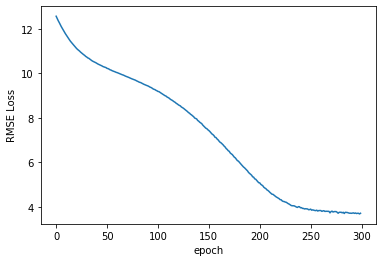

In [37]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

## Validate the model
Here we will run the entire test set through the model, and compare it to the known labels.<br>
For this step we don't want to update weights and biases, so we set <tt>torch.no_grad()</tt>

In [38]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.67019439


This means that on average, predicted values are within &plusmn;$3.31 of the actual value.

Now let's look at the first 50 predicted values:

In [39]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.   4.7426   2.9000   1.8426
 2.  26.1112   5.7000  20.4112
 3.   5.1841   7.7000   2.5159
 4.  14.3067  12.5000   1.8067
 5.   5.2253   4.1000   1.1253
 6.   4.5007   5.3000   0.7993
 7.   5.3350   3.7000   1.6350
 8.  13.3732  14.5000   1.1268
 9.   3.8609   5.7000   1.8391
10.  10.0797  10.1000   0.0203
11.   4.5116   4.5000   0.0116
12.   3.7237   6.1000   2.3763
13.   6.4951   6.9000   0.4049
14.  13.9177  14.1000   0.1823
15.   4.9265   4.5000   0.4265
16.  26.2499  34.1000   7.8501
17.   5.3196  12.5000   7.1804
18.   2.8553   4.1000   1.2447
19.  12.0269   8.5000   3.5269
20.   6.2697   5.3000   0.9697
21.  13.9912  11.3000   2.6912
22.   8.9382  10.5000   1.5618
23.  15.1454  15.3000   0.1546
24.  15.2450  14.9000   0.3450
25.  36.4633  49.5700  13.1067
26.   4.5268   5.3000   0.7732
27.   3.7062   3.7000   0.0062
28.   7.8601   6.5000   1.3601
29.  13.9043  14.1000   0.1957
30.   4.8753   4.9000   0.0247
31.   5.8894   3.7000   2.1894
32.  40.

## Save the model


In [36]:

if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareNYCANNModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')